In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend as K

# To prevent CUBLAS_STATUS_ALLOC_FAILED problem in tensorflow 2, the follwing codes are necessary.

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


# **Autoencoders**

자동 인코더는 입력 데이터에 유용한 변환을 수행하기 위해 표현 또는 코드 조각을 찾으려고 시도합니다.<br>
ex) Autoencoder의 소음을 제거할 때, 신경망은 노이즈가 있는 데이터를 깨끗한 데이터로 변환하는 데 사용할 수 있는 코드를 찾으려고 합니다.

자동 인코더는 사람의 라벨링 없이 데이터만으로 코드를 자동으로 학습합니다.<br>따라서 자동 인코더는 감독되지 않은 학습 알고리즘에 따라 분류될 수 있습니다.

자동 인코더는 입력 분포를 일반적으로 벡터 형식을 취하는 저차원 텐서로 인코딩합니다.<br> 이것은 일반적으로 잠재 표현, 코드 또는 벡터로 언급되는 숨겨진 구조에 근접할 것입니다.<br> 이 프로세스는 인코딩 부분을 구성합니다. 그런 다음 원래 입력을 복구하기 위해 디코더 부분에 의해 잠복 벡터가 디코딩됩니다.

잠재 벡터가 입력 분포의 저차원 압축 표현이기 때문에, 디코더에 의해 복구된 출력은 입력에 근사치만 낼 수 있다고 예상해야 합니다.<br>
입력과 출력의 차이는 손실 함수로 측정할 수 있습니다.

Deep Learning은 밀도 추정에 적합한 데이터를 저차원적으로 표현하기 때문에 심화 학습 주제를 이해하는 데 핵심적인 도구입니다.<br> 또한 입력 데이터에 대한 구조적 연산을 효율적으로 처리할 수 있습니다.<br> 일반적인 작업에는 잡음 제거, 색화, 기능 수준 산술, 탐지, 추적 및 분할이 포함됩니다.

첫째, 자동 인코더에는 다음과 같은 두 개의 연산자가 있다는 것을 알아야 합니다.
- 인코더 : 입력 x를 저차원 잠복 벡터 z=f(x)로 변환합니다. 잠복 벡터가 저차원이기 때문에 인코더는 입력 데이터의 가장 중요한 특징만 학습해야 합니다. 예를 들어 MNIST 자릿수의 경우 배워야 할 중요한 특징으로는 쓰기 스타일, 기울기 각도, 스트로크의 원형, 두께 등이 있습니다. 본질적으로, 이것들은 0부터 9까지의 숫자를 나타내는 데 필요한 가장 중요한 정보들입니다.

- 디코더 : 잠복 벡터 $g(z) = \tilde{x}$ 에서 입력을 복구합니다.<br>
잠복 벡터의 치수는 낮지만 디코더가 입력 데이터를 복구할 수 있는 충분한 크기를 가지고 있습니다.

디코더의 목표는 이미지를 x에 최대한 가깝게 만드는 것입니다.<br> 일반적으로 인코더와 디코더는 모두 비선형 기능입니다.<br> z의 치수는 나타낼 수 있는 두드러진 특징의 수를 측정한 것입니다.<br> 이 치수는 일반적으로 효율성을 위해 입력 치수보다 훨씬 작으며 입력 분포의 가장 중요한 특성만을 학습하기 위해 잠복 코드를 제한합니다.

적절한 손실 함수인 $\mathcal{L}(x,\tilde{x})는 입력 x가 출력(복구된 입력, 
\tilde{x}$)과 얼마나 다른지 측정한 값입니다.

 ![image.png](attachment:image.png)

m은 출력 치수입니다(예: MNIST m = 폭 × 높이 × 채널 = 28 × 1 = 784).<br>
xi와 이미지는 각각 x와 이미지의 요소입니다. 손실 함수는 입력과 출력의 차이 측정치이기 때문에<br> 이진 교차 엔트로피 또는 구조 유사성 지수(SSIM)와 같은 대체 재구성 손실 함수를 사용할 수 있습니다.

다른 신경망과 마찬가지로, 오토 인코더는 훈련 중에 이 오류나 손실이 가능한 작게 기능하도록 노력합니다.

 ![image.png](attachment:image.png)

인코더는 입력 $x$를 저차원 잠재 벡터 $z$로 압축하는 함수입니다. 이 잠재 벡터는 입력 분포의 중요한 특징을 나타냅니다. 그런 다음 디코더는 잠재 벡터로부터 $\tilde{x}$의 형태로 원래 입력을 복구하려고 시도합니다.

자동 인코더를 컨텍스트에 넣으려면 $x$는 28 × 28 × 1 = 784 치수의 MNIST 자릿수일 수 있습니다. 인코더는 입력을 16차원 잠재 벡터가 될 수 있는 저차원 $z$로 변환합니다. 디코더가 $z$에서 이미지 형식의 입력을 복구하려고 시도합니다.

![image-3.png](attachment:image-3.png)

# **Building an autoencoder for mnist data using Keras**

## Stage 1 : Encoder

인코더는 두 Conv2D의 스택입니다. 마지막 단계는 잠복 벡터를 생성하기 위한 16개의 유닛이 있는 조밀 레이어입니다.<br>
![image.png](attachment:image.png)

In [3]:
# Step 1: Data Preparation
(x_train, _), (x_test, _) = mnist.load_data()
print(x_train.shape)
print(x_test.shape)
# data preprocessing : Reshape and nomalization
image_size = x_train.shape[1]

x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])

x_train = x_train/255.
x_test = x_test/255.

11501568/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)


Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 16)                50192     
Total params: 69,008
Trainable params: 69,008
Non-trainable params: 0
_________________________________________________________________


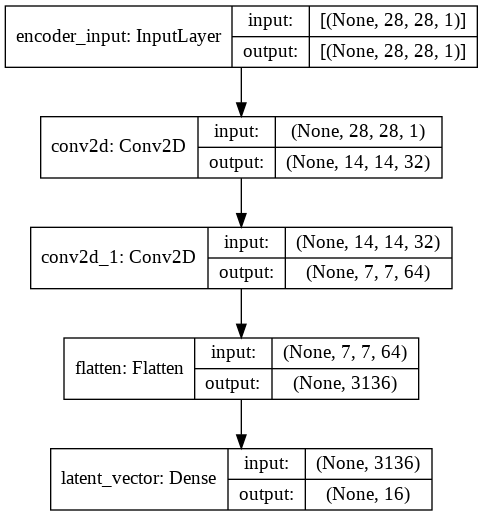

In [5]:
# Step 2 : Autoencoder model construction

# Set those hyperparameters

input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
latent_dim = 16 # encoder/decoder number of CNN layers and filters per layer
layer_filters = [32, 64]

# Encoder Model
inputs = Input(shape=input_shape, name = 'encoder_input')
x = inputs # stack of Conv2DTranspose(32) - Conv2DTranspose(64)
for filters in layer_filters:
    x = Conv2D(filters = filters, kernel_size = kernel_size,
                activation = 'relu',
               strides = 2,
               padding = 'same') (x)

# 디코더 모델 구축에 필요한 모양 정보
# 그래서 우리는 손 계산을 하지 않는다.
# 디코더의 첫 Conv2DTranspose에 대한 입력은 이 모양을 갖습니다.
# 모양은 (7,7,64)이며, 디코더에 의해 (28,28,1)로 다시 처리됩니다.

shape = K.int_shape(x)
#. 디코더의 치수를 계산하기 위해 마지막 Conv2D 출력 모양이 저장됩니다.
# MNIST 이미지의 손쉬운 재구성을 위한 입력 레이어: shape = K.int_shape(x)

# generate latent vector

x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# instantiate encoder model (인스턴스 인코더)

encoder = Model(inputs, latent, name = 'encoder')
encoder.summary()
plot_model(encoder, show_shapes = True)

# **Stage 2 (Decoder)**

디코더는 MNIST 자릿수를 복구하기 위해 잠복 벡터의 압축을 해제합니다.<br> 디코더 입력 단계는 잠복 벡터를 수용하는 조밀 레이어입니다. 장치 수는 인코더에서 저장된 Conv2D 출력 치수의 곱과 동일합니다.<br> 이렇게 하면 Conv2DTranspose용 조밀 레이어의 출력 크기를 쉽게 조정하여 원본 MNIST 이미지 치수를 복구할 수 있습니다.

디코더는 3개의 Conv2DTranspose 스택으로 구성됩니다.<br> 우리의 경우, 디코더에서 더 일반적으로 사용되는 Transposed CNN(때로는 디콘볼루션이라고도 함)을 사용할 것입니다.<br> CNN의 역순으로 CNN(Conv2DTransposse)을 상상할 수 있습니다.

간단한 예로, CNN이 이미지를 피쳐 맵으로 변환하면 이전된 CNN이 주어진 피쳐 맵을 생성합니다.

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 16)]              0         
_________________________________________________________________
dense_2 (Dense)              (None, 3136)              53312     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 28, 28, 1)         289       
Total params: 108,993
Trainable params: 108,993
Non-trainable params: 0
_____________________________________________________

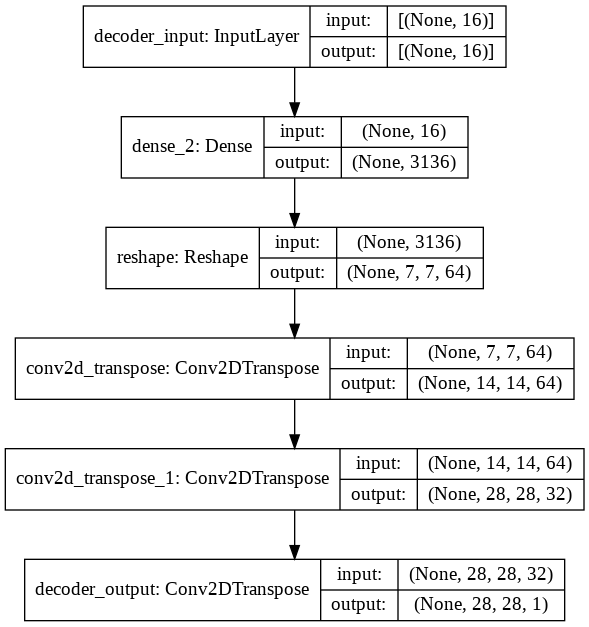

In [9]:
# Decoder Modle

latent_inputs = Input(shape=(latent_dim,), name='decoder_input') # 인코더의 output

# use the shape(7, 7, 64) that was earlier saved [ 3136 ]
x = Dense(shape[1] * shape[2] * shape[3]) (latent_inputs)

# from vector to suitable shape for transposed conv
x = Reshape((shape[1], shape[2], shape[3]))(x)

# stack of Conv2DTranspose(64) - Conv2DTranspose(32)
for filters in layer_filters[::-1]: # 거꾸로
    x = Conv2DTranspose(filters = filters, kernel_size = kernel_size,
               activation = 'relu',
               strides =2,
               padding = 'same') (x)

# reconstruct the input
    outputs = Conv2DTranspose(filters = 1, kernel_size=kernel_size,
                              activation='sigmoid',
                              padding='same',
                              name='decoder_output') (x)

# instantiate decoder model

decoder = Model(latent_inputs, outputs, name = 'decoder')
decoder.summary()

plot_model(decoder, show_shapes=True)

# **Build autoencoder = encoder + decoder**

![image.png](attachment:image.png)

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Functional)         (None, 16)                69008     
_________________________________________________________________
decoder (Functional)         (None, 28, 28, 1)         108993    
Total params: 178,001
Trainable params: 178,001
Non-trainable params: 0
_________________________________________________________________


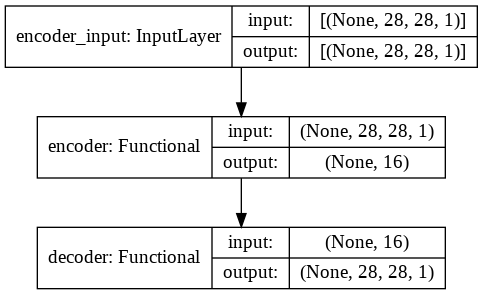

In [10]:
# Model autoencoder = encoder + decoder

autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()
plot_model(autoencoder, show_shapes=True)


In [11]:
# Step 3: Model Compile

autoencoder.compile(loss='mse', optimizer='adam')

# Step 4: Model Fit

autoencoder.fit(x_train, 
                x_train, 
                validation_data=(x_test,x_test),
                epochs=1,
                batch_size=batch_size)

1875/1875 [==============================] - 46s 9ms/step - loss: 0.0216 - val_loss: 0.0105


(10000, 28, 28, 1)
(16, 28, 28, 1)


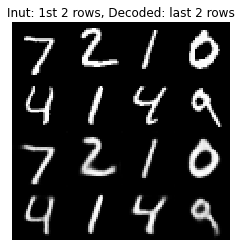

In [22]:
# Step 5: Model evaluation & prediction

# predict the autoencoder output from test validation_data

x_decoded = autoencoder.predict(x_test)

# display the first 8 test input and decoded images
# 처음 8개의 테스트 입력 및 디코딩된 이미지를 표시합니다.

images = np.concatenate([x_test[:8], x_decoded[:8]])

images=images.reshape((4,4, image_size, image_size))
images = np.vstack([np.hstack(i) for i in  images])

plt.figure()
plt.axis('off')
plt.title('Inut: 1st 2 rows, Decoded: last 2 rows')
plt.imshow(images, interpolation='none', cmap='gray')
plt.savefig('input_and_decoded.png')
plt.show()

# **At this point, we may be wondering: how can we visualize the latent vector in space?**
## 이 시점에서, 우리는 궁금할 수 있다: 우리가 어떻게 우주에서의 잠재 벡터를 시각화할 수 있을까?

간단한 시각화 방법은 2-dim 잠재 벡터를 사용하여 자동 인코더가 MNIST 자릿수 특성을 학습하도록 하는 것입니다.<br> MNIST 잠재 벡터가 어떻게 분포되어 있는지 보기 위해 이 잠재 벡터를 2차원 공간에 투영할 수 있습니다.

그림 3.2.5와 그림 3.2.6은 잠복 코드 치수의 함수로서 MNIST 자릿수의 분포를 보여줍니다.

![image.png](attachment:image.png)

![image-2.png](attachment:image-2.png)